# Operational contracts in object detection

Goal: make the detection pipeline inspectable:
candidates (boxes + scores) -> threshold -> IoU -> NMS.

Each step is in its own cell so you can see behavior changes clearly.

## 1. Workspace information

In [ ]:
!uname -a

!free -h || true

!cat /proc/cpuinfo | head -n 20 || true

## 2. Workspace setup (Colab-friendly)

In [1]:
try:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive')
except Exception:
    pass

import os
import glob

my_name = '02_tensorflow_detection_contract.ipynb'
my_path = glob.glob(os.getcwd() + '/**/' + my_name, recursive=True)

if my_path:
    nb_dir = os.path.dirname(my_path[0])
    os.chdir(os.path.abspath(os.path.join(nb_dir, '..')))

print("Current dir:", os.getcwd())
!ls


Mounted at /content/drive
Current dir: /content/drive/MyDrive/Colab Notebooks/operational-ai-field-notes
data	   pyproject.toml	 requirements-tf.txt	 src
LICENSE    README.md		 requirements-torch.txt  tests
notebooks  requirements-dev.txt  requirements-yolo.txt


## 3. Load demo images

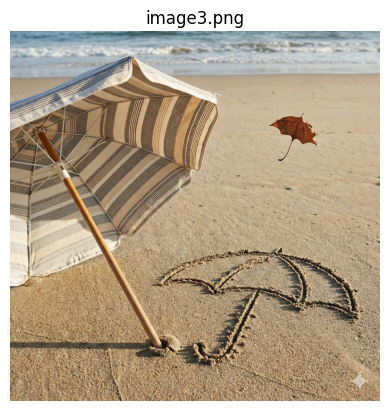

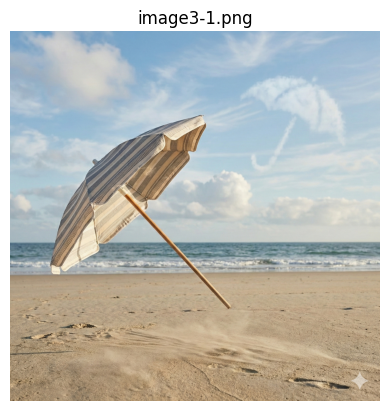

In [2]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

img_dir = Path("data/input/images")
img1 = Image.open(img_dir / "image3.png").convert("RGB")
img2 = Image.open(img_dir / "image3-1.png").convert("RGB")

def show(img, title: str) -> None:
    plt.figure()
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.show()

show(img1, "image3.png")
show(img2, "image3-1.png")


## 4. Install TensorFlow stack
This notebook aligns with SSD + MobileNet in TensorFlow via TF Hub.

In [3]:
!pip -q install -r requirements-dev.txt
!pip -q install -r requirements-tf.txt
!pytest -q

.....                                                                    [100%]
5 passed in 2.69s


## 5. Run a real detector (TF Hub SSD + MobileNet)
TF Hub model URLs can change. The adapter tries a short fallback list.

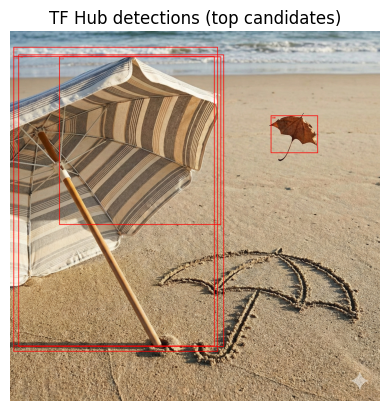

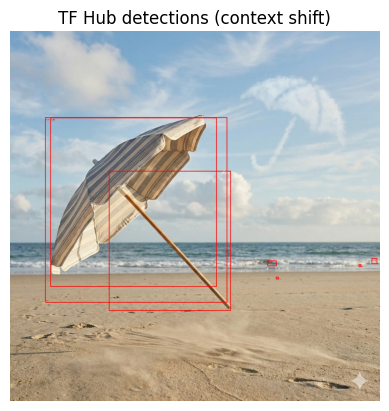

20 [0.6348912715911865, 0.526151180267334, 0.5101875066757202, 0.40329843759536743, 0.39663806557655334]
20 [0.8923057913780212, 0.4339260756969452, 0.3067973256111145, 0.17777858674526215, 0.17503242194652557]


In [5]:
from src.tfhub_det import run_tfhub_ssd_mobilenet
from src.viz import draw_boxes

res = run_tfhub_ssd_mobilenet(img1, max_detections=20)
res2 = run_tfhub_ssd_mobilenet(img2, max_detections=20)

vis = draw_boxes(img1, res.boxes[:10], scores=res.scores[:10], color="red")
vis2 = draw_boxes(img2, res2.boxes[:10], scores=res2.scores[:10], color="red")

show(vis, "TF Hub detections (top candidates)")
show(vis2, "TF Hub detections (context shift)")

print(len(res.boxes), res.scores[:5])
print(len(res2.boxes), res2.scores[:5])

## Contract demo (framework-independent)
Even if a pretrained detector outputs little on synthetic images, the contract is the point.
We create toy duplicates to make thresholding and NMS effects visible.

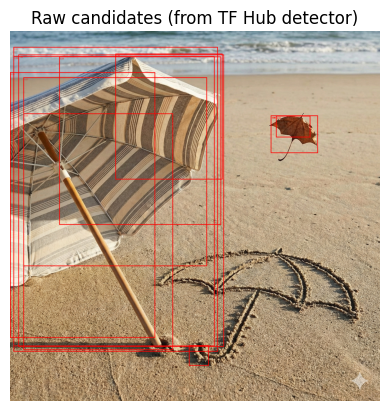

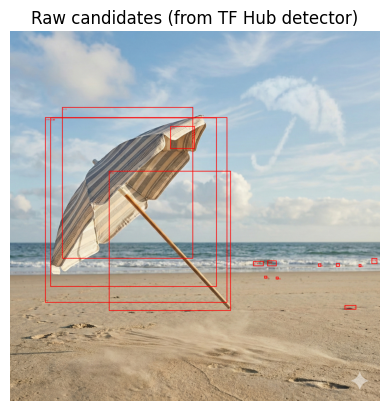

In [6]:
from src.boxes import Box
from src.contracts import apply_threshold, nms
from src.viz import draw_boxes

# Using the actual results from the TF Hub detector
real_boxes = res.boxes
real_boxes2 = res2.boxes

real_scores = res.scores
real_scores2 = res2.scores

raw = draw_boxes(img1, real_boxes, scores=real_scores, color="red")
raw2 = draw_boxes(img2, real_boxes2, scores=real_scores2, color="red")

show(raw, "Raw candidates (from TF Hub detector)")
show(raw2, "Raw candidates (from TF Hub detector)")

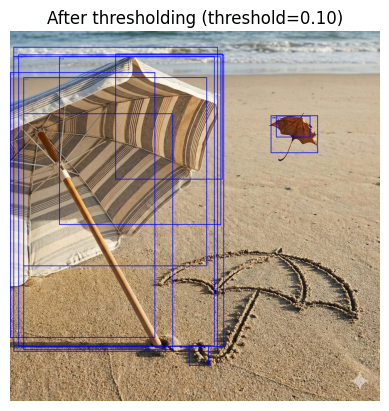

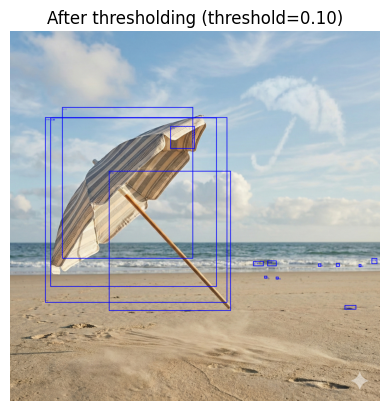

In [7]:
thr = 0.10
b, s = apply_threshold(real_boxes, real_scores, threshold=thr)
b2, s2 = apply_threshold(real_boxes2, real_scores2, threshold=thr)

vis = draw_boxes(img1, b, scores=s, color="blue")
vis2 = draw_boxes(img2, b2, scores=s2, color="blue")

show(vis, f"After thresholding (threshold={thr:.2f})")
show(vis2, f"After thresholding (threshold={thr:.2f})")

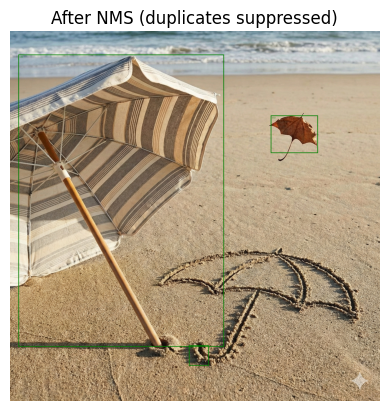

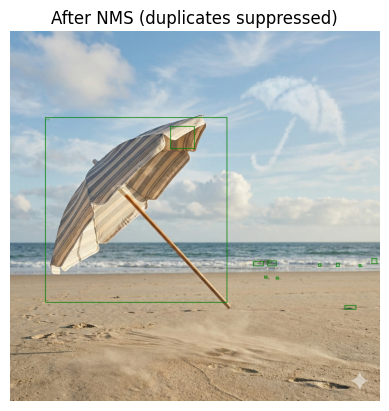

In [8]:
keep = nms(b, s, iou_threshold=0.15)
kept_b = [b[i] for i in keep]
kept_s = [s[i] for i in keep]

keep2 = nms(b2, s2, iou_threshold=0.15)
kept_b2 = [b2[i] for i in keep2]
kept_s2 = [s2[i] for i in keep2]

vis = draw_boxes(img1, kept_b, scores=kept_s, color="green")
vis2 = draw_boxes(img2, kept_b2, scores=kept_s2, color="green")

show(vis, "After NMS (duplicates suppressed)")
show(vis2, "After NMS (duplicates suppressed)")